# Masking

In [ ]:
import os
import cv2
import csv
from tqdm import tqdm
import kornia as K
import kornia.feature as KF
import kornia.morphology as morph
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import torch
import torch.nn.functional as F
# from kornia_moons.viz import draw_LAF_matches
import skimage as ski
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
from IPython.display import clear_output, display, DisplayHandle

from loftr import * 
from utils import *
from DatasetTools.LeafImageSeries import LeafDataset
from DatasetTools.LeafImageSeries import KeypointEditor

## Loading Images

In [2]:
base_dir = '../leaf-image-sequences'
# base_dir = '../leaf-image-sequences-subset'
# base_dir = '../test-webdav-connection'
print(os.path.exists(base_dir))
print(os.path.exists(base_dir+'/raw'))

True
True


In [3]:
# base_dir = '../leaf-image-sequences'
base_dir = '../leaf-image-sequences-subset'
# base_dir = '../test-webdav-connection'
assert os.path.exists(base_dir), "Path to base directory invalid"
assert os.path.exists(base_dir+'/raw'), "Base directory empty"

leaf = LeafDataset(
    base_dir=base_dir,
    # leaf_uid="ESWW0090057_18", 
    leaf_uid="ESWW0070020_1", 
    # load=('images', 'rois', 'tforms', 'target_masks', 'leaf_masks', 'instance_masks', 'det_masks', 'seg_masks', 'target_images', "keypoints")
    load=('images', 'rois', "keypoints"),
    verbose=True
)

Initializing dataset...
Getting Series...
Getting paths...
Extracting IDs...
Removing duplicate IDs...
Filtering by leaf_uid...
Compiling list...
Loading requested values...
Loading images...
Loading ROIs...
Loading keypoints...


In [4]:
available_data = {
            key: value for key, value in leaf.__dict__.items()
            if not key.startswith('_') and value is not None
        }
available_data.keys()

dict_keys(['base_dir', 'leaf_uid', 'series', 'image_uids', 'output_base', 'output_reg', 'output_ts', 'shift_affine', 'images', 'rois', 'keypoints'])

In [5]:
available_data['rois'][3]
# available_data['rois'][3]['rotation_matrix']

{'rotation_matrix': [[0.9999479121098008,
   -0.010206520820045598,
   28.097566878620377],
  [0.010206520820045598, 0.9999479121098008, -41.66360516288263]],
 'bounding_box': [[1343, 3176], [6287, 3176], [6287, 3987], [1343, 3987]],
 'transformation_matrix': [[0.9926017441720136,
   -0.03645819677532361,
   10.838102190732412],
  [0.00492382188196885, 1.016519616054494, -18.09833064407817],
  [2.143680248720033e-06, -2.2731286925450572e-05, 1.0]]}

## Aligning Keypoints

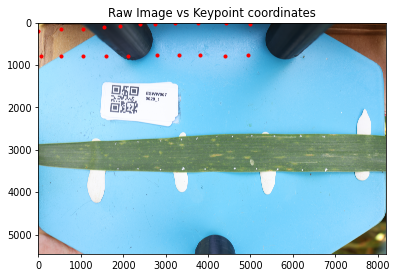

In [5]:
index = 4
plt.figure(dpi=70)
plt.imshow(available_data['images'][index])
plt.scatter(available_data['keypoints'][index][:,0], available_data['keypoints'][index][:,1], c='red', s=10 )
plt.title("Raw Image vs Keypoint coordinates")
plt.show()

In [6]:
# convert keypoint coords to full image coords
kpts_img = keypoints_roi_to_image(available_data['keypoints'][index], available_data['rois'][index])

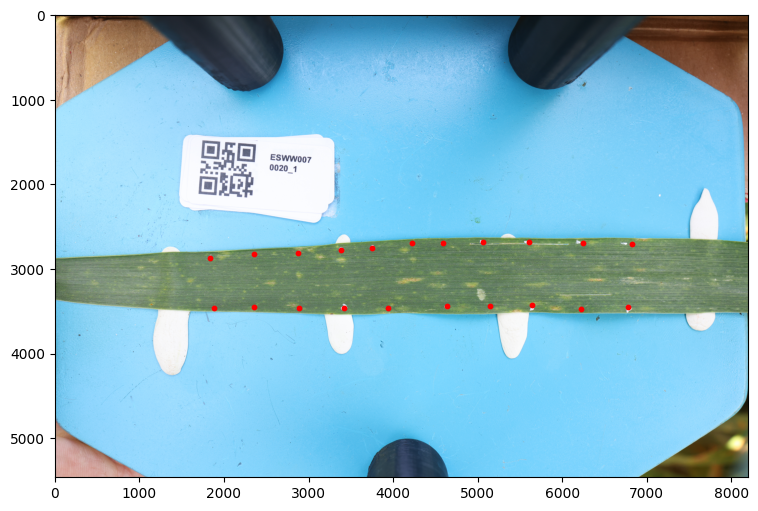

In [7]:
plt.figure(figsize=(12,6))
plt.imshow(available_data['images'][index])
plt.scatter(kpts_img[:,0], kpts_img[:,1], c='red', s=10 )
plt.show()

## Masking & Erosion

In [10]:
masked_img, mask_t, center = mask_leaf(available_data['images'][index], kpts_img, erode_px=20)

erosion not yet functional


In [62]:
# mean = np.mean(hull, axis=0)
# print(f"mean = {mean}")
# mx = np.max(hull, axis=0)
# mn = np.min(hull, axis=0)
# mid = (mx+mn)/2
# print(f"min = {mn}, max = {mx}")
# print(f"mid = {mid}")

mean = [[4884.5  3000.25]]
min = [[1830 2675]], max = [[6831 3469]]
mid = [[4330.5 3072. ]]


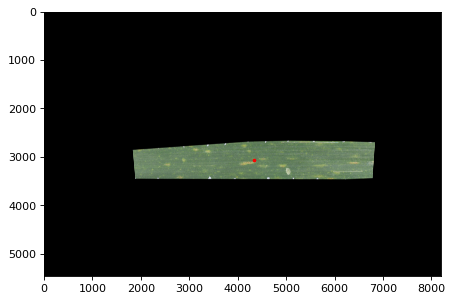

In [11]:
plt.figure(dpi=80)
plt.imshow(K.tensor_to_image(masked_img))
plt.scatter(center[0][0], center[0][1], c='red', s=5, label='center')
# plt.scatter(mean[0][0], mean[0][1], c='yellow', s=5, label='mean')
# plt.scatter(mid[0][0], mid[0][1], c='cyan', s=5, label='middle')
plt.show()

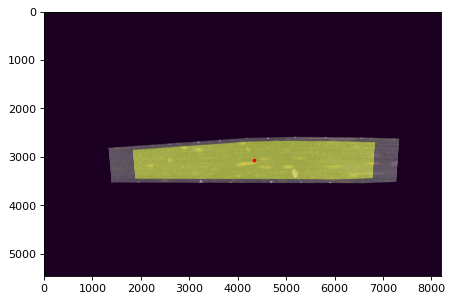

In [ ]:
img_scaled = scale_image(masked_img, 1.2, center)

plt.figure(dpi=80)
plt.imshow(K.tensor_to_image(img_scaled))
plt.imshow(K.tensor_to_image(mask_t), alpha=0.4)
plt.scatter(center[0][0], center[0][1], c='red', s=5)
plt.show()

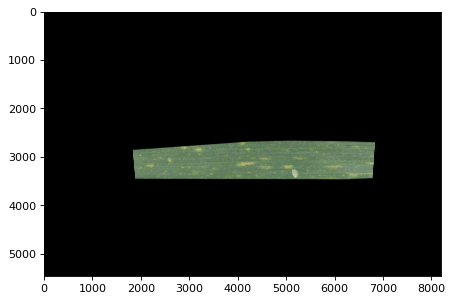

In [13]:
masked_scaled_img = img_scaled * mask_t 
plt.figure(dpi=80)
plt.imshow(K.tensor_to_image(masked_scaled_img))
plt.show()

In [25]:
# eroded_mask = erode_mask_by_scaling(mask_t, scale=0.9)

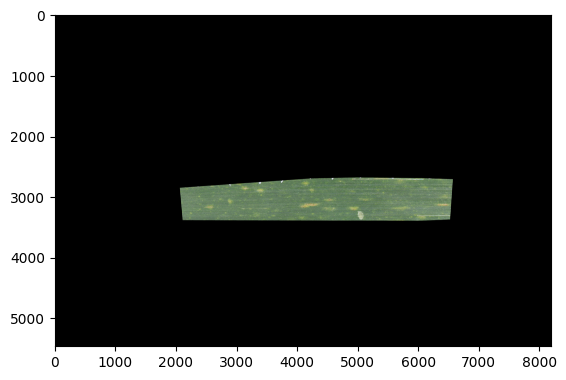

In [20]:
# masked_scaled_img = masked_img * eroded_mask
# plt.figure(dpi=80)
# plt.imshow(K.tensor_to_image(masked_scaled_img))
# plt.show()

### LoFTR Quick Test

In [29]:
H=1366 
W=2048 
moving_img = K.geometry.resize(masked_scaled_img, (H, W), antialias=True)
fixed_img = pil_to_kornia(available_data['images'][0])
fixed_img = K.geometry.resize(fixed_img, (H, W), antialias=True)

Total matches: 802
Matches with Confidence > 0.5: 377
Inliers: 214 (26.68%)


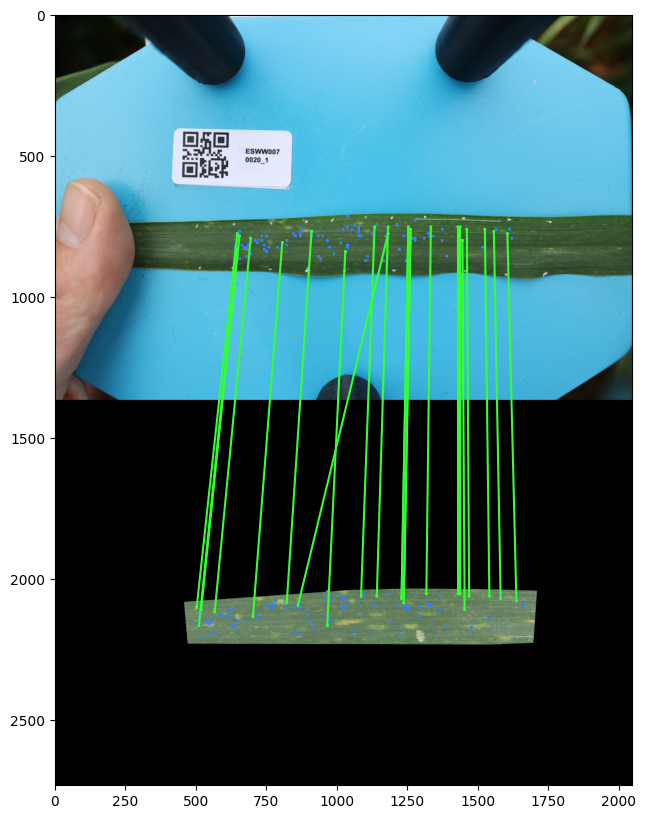

In [30]:
mkpts1, mkpts2, confidence, inliers = loftr_match(fixed_img, moving_img)

# plot matches
fig, ax = plot_matches(fixed_img, mkpts1, moving_img, mkpts2, inliers, inliers_only=False)
fig.show()

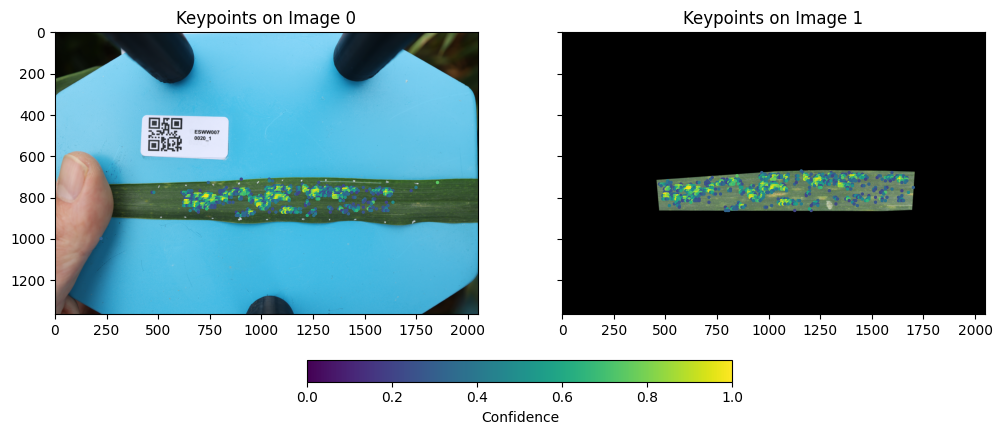

In [31]:
fig, axs = plot_match_coverage(fixed_img, mkpts1, moving_img, mkpts2, confidence)
fig.show()

### Erode + Crop

In [11]:
index = 1
kpts_img = keypoints_roi_to_image(available_data['keypoints'][index], available_data['rois'][index])
masked_img, mask_t, center, bounds = mask_leaf(available_data['images'][index], kpts_img, erode_px=0, return_center=True, return_bounds=True)
bounds

[array([2468, 2726], dtype=int32), array([7462, 3627], dtype=int32)]

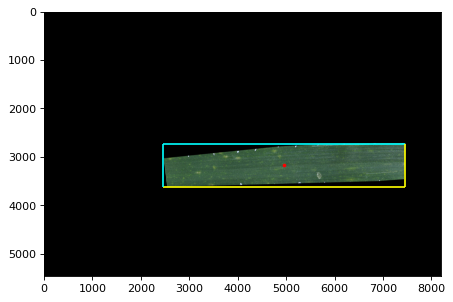

In [12]:
x_min, y_min = bounds[0]
x_max, y_max = bounds[1]
plt.figure(dpi=80)
plt.imshow(K.tensor_to_image(masked_img))
plt.scatter(center[0], center[1], c='red', s=5, label='center')
plt.hlines(y=y_min, xmin=x_min, xmax=x_max, colors='cyan')
plt.hlines(y=y_max, xmin=x_min, xmax=x_max, colors='yellow')
plt.vlines(x=x_min, ymin=y_min, ymax=y_max, colors='cyan')
plt.vlines(x=x_max, ymin=y_min, ymax=y_max, colors='yellow')
plt.show()

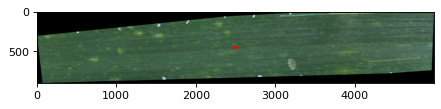

In [22]:
cropped_img, new_center = crop_img(masked_img, x_min, x_max, y_min, y_max, center)
cropped_mask = crop_img(mask_t, x_min, x_max, y_min, y_max)
plt.figure(dpi=80)
plt.imshow(K.tensor_to_image(cropped_img))
plt.scatter(new_center[0], new_center[1], c='red', s=5, label='center')
plt.show()

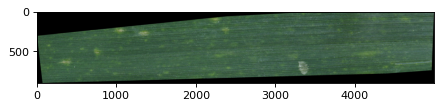

In [23]:
img_scaled = scale_image(cropped_img, 1.2, new_center)
masked_scaled_img = img_scaled * cropped_mask 
plt.figure(dpi=80)
plt.imshow(K.tensor_to_image(masked_scaled_img))
plt.show()

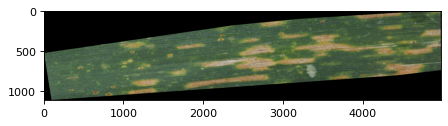

In [26]:
crop_test = erode_crop_leaf(available_data, 13)
plt.figure(dpi=80)
plt.imshow(K.tensor_to_image(crop_test))
plt.show()

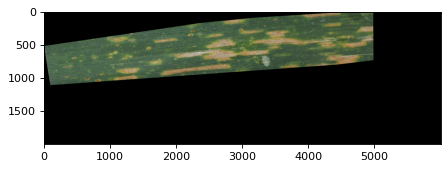

In [32]:
padder = K.augmentation.PadTo((2000,6000))
pad_test = padder(crop_test)
plt.figure(dpi=80)
plt.imshow(K.tensor_to_image(pad_test))
plt.show()

## LoFTR

In [13]:
# ind = 2 
# img0 = available_data['images'][index]
# img1 = available_data['images'][index+1]
# keypts_img0 = keypoints_roi_to_image(available_data['keypoints'][index], available_data['rois'][index])
# keypts_img1 = keypoints_roi_to_image(available_data['keypoints'][index+1], available_data['rois'][index+1])

In [14]:
# masked_img0, mask_t0 = mask_leaf(img0, keypts_img0)
# masked_img1, mask_t1 = mask_leaf(img1, keypts_img1)

In [15]:
# eroded_mask0 = erode_mask_by_scaling(mask_t0, scale=0.9)
# eroded_mask1 = erode_mask_by_scaling(mask_t1, scale=0.9)

In [16]:
# masked_scaled_img0 = masked_img0 * eroded_mask0
# masked_scaled_img1 = masked_img1 * eroded_mask1

In [ ]:
# plt.imshow(K.tensor_to_image(masked_scaled_img1))
# plt.show()

## Robustness Test

- rotation: 0 → ±30° (steps: 5°)
- translation: 0 → ±20% image width/height (steps: 5%)
- scale: 1.0 → 0.6–1.4 (steps: 0.1)
- brightness/contrast/gamma: 1.0 → [0.5, 1.5] (steps: 0.1)
- hue shift: 0 → ±0.1 (normalized) (steps: 0.02)
- saturation: 1.0 → [0.5, 1.5] (steps: 0.1)
- gaussian noise: σ = 0 → 0–25 (pixel value std, steps: 5)
- gaussian blur: kernel size 1 → 1,3,5,7
- ( jpeg quality: 100 → 100, 85, 60, 40, 20 )
- ( occlusion (cutout): occlusion area 0% → up to 40% of image (steps: 5–10%) )

In [8]:
transforms = {
    'Rotation': list(range(-30, 40, 10)),        # -30,...,-5,0,5,10,...,30 degrees
    'Translation': list(range(-20, 30, 10)),     # +/- 20% of image width/height
    'Scale': [0.5, 0.75, 1.25, 1.5], #list(range(0.5, 1.5, 0.25)),        # 0.5-1.5
    'Brightness': [0.1, 0.3, 0.5], #[0.0, 0.1, 0.2, 0.4, 0.5],    # 0 = no changes
    'Contrast': [0.8, 0.6], #[1.0, 0.9, 0.8, 0.7, 0.6],      # 1 = no changes, 0 = completely black
    'Gamma': [0.8, 1.0, 1.2], #[0.8, 0.9, 1.0, 1.1, 1.2],         # <1 -> dark regions lighter, >1 -> dark regions darker
    'Hue': [-0.05, 0.05],# list(range(-0.1, 0.1, 0.05)),       # 0 = no shift
    'Saturation': [0.75, 1.25],#list(range(0.5, 1.5, 0.1)),    # 1 = no changes, 0 = black&white, >1 = more saturated
    'Gaussian Noise': [0.5],#[0, 0.25, 0.5, 0.75, 1],           # 0 = no changes, higher = more noise
    'Gaussian Blur': [21, 51],#[11, 21, 51, 101, 151],
}
size_factors = [2]#[1, 2, 4, 8]
backgrounds = ["Eroded+Cropped"] #"Original", "Eroded", 
fixed_img_indices = [1]
moving_img_indices = [13, 3] #13

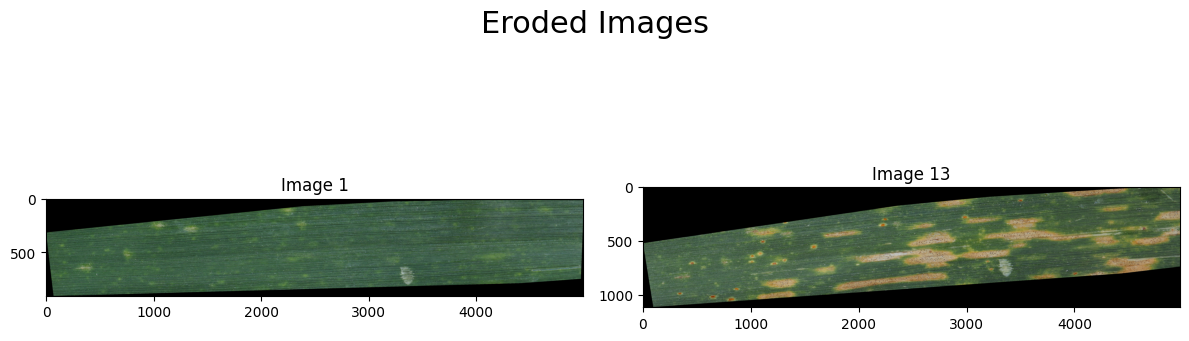

In [30]:
fixed, moving = fetch_leaves([fixed_img_indices[0], moving_img_indices[-1]], available_data, background_type="Eroded+Cropped")
plot_image_pair(fixed, moving, fixed_img_indices[0], moving_img_indices[-1], title="Eroded Images")
plt.show()

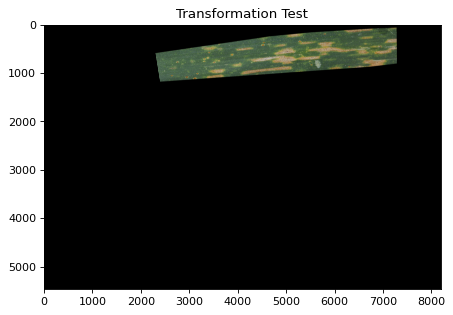

In [16]:
# trsf = K.augmentation.RandomAffine(30, (0.2, 0.2), (0.5, 1.5))
# test = trsf(moving_img)
test = affine(moving_img, 0, 0, -50, 1)
# test = adjust_color(moving_img, 1.5, 1.5)
# test = add_gaussian_noise(moving_img, sigma=0.5)
magnitude = 11
# test = K.filters.gaussian_blur2d(moving_img, kernel_size=torch.tensor([magnitude, magnitude]), sigma=torch.tensor([magnitude, magnitude]),)
# test= gaussian_blur(moving_img, kernel_size=magnitude, sigma=magnitude)
plt.figure(dpi=80)
plt.imshow(K.tensor_to_image(test))
plt.title("Transformation Test")
plt.show()

In [9]:
out_file = "robustness_results2.csv"
thrsld = 0.5
file_exists = os.path.exists(out_file)

clear_output(wait=True)
handle = display(display_id=True)

with open(out_file, 'a', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=['fixed_image', 'moving_image', 'background', 'size','transform','magnitude','total_matches', 'conf_matches', 'inliers', 'mse', 'ssim', 'ncc', 'mi'])
    
    if not file_exists: # if file is new, write the header
        writer.writeheader()

    for fixed_img_ind in fixed_img_indices:
        for moving_img_ind in moving_img_indices:

            for background in backgrounds:
                fixed_img_full, moving_img_full = fetch_leaves([fixed_img_ind, moving_img_ind], available_data, background_type=background)

                if background == "Eroded+Cropped":
                    # cropped images are likely of different dimensions -> pad them to match
                    height = max(fixed_img_full.shape[-2], moving_img_full.shape[-2])
                    width = max(fixed_img_full.shape[-1], moving_img_full.shape[-1])

                    padder = K.augmentation.PadTo((height, width))

                    fixed_img_full = padder(fixed_img_full)
                    moving_img_full = padder(moving_img_full)
                else:
                    height = fixed_img_full.shape[-2]
                    width = fixed_img_full.shape[-1]

                for size_factor in size_factors:
                    H = int(height/size_factor)
                    W = int(width/size_factor)  
                    fixed_img = K.geometry.resize(fixed_img_full, (H, W), antialias=True)
                    moving_img = K.geometry.resize(moving_img_full, (H, W), antialias=True) 

                    # original images
                    
                    if background == "Original":
                        fig, _ = plot_image_pair(fixed_img, moving_img, fixed_img_ind, moving_img_ind, title=f"Original Images,   Size: 1/{size_factor}")
                        handle.update(fig)   
                        plt.close(fig)

                        mkpts0, mkpts1, confidence, _, n_matches = loftr_match(fixed_img, moving_img, verbose=False, return_n_matches=True)
                        
                        # TPS
                        warped, tps = tps_skimage(mkpts0, mkpts1, confidence, thrsld, moving_img, verbose=True)
                        mse_val = mean_squared_error(K.tensor_to_image(fixed_img), warped)
                        ssim_val, _ = ssim(K.tensor_to_image(fixed_img), warped, channel_axis=-1, data_range=(warped.max() - warped.min()), full=True) 
                        ncc_val = ncc(fixed_img, warped).item()
                        mi_val = mutual_information(fixed_img, warped).item()
                        
                        writer.writerow({'fixed_image': fixed_img_ind, 'moving_image': moving_img_ind, 'background': background, 'size': f"1/{size_factor}", 'transform': None, 'magnitude': None, 'total_matches': n_matches['total_matches'], 'conf_matches': int(n_matches['conf_matches']), 'inliers': n_matches['inliers'], 'mse': mse_val, 'ssim': ssim_val, 'ncc': ncc_val, 'mi': mi_val})
                        continue

                    for tname, magnitudes in transforms.items():
                        for mag in magnitudes:
                            transformed_img = transform_img(moving_img, tname, mag)

                            # plot current image pair
                            fig, _ = plot_image_pair(fixed_img, transformed_img, fixed_img_ind, moving_img_ind, title=f"Transform: {tname},  Magnitude: {mag},   Size: 1/{size_factor}")
                            handle.update(fig)   
                            plt.close(fig)

                            mkpts0, mkpts1, confidence, _, n_matches = loftr_match(fixed_img, transformed_img, verbose=False, return_n_matches=True)

                            # print(n_matches)
                            if n_matches['conf_matches'] > 3:
                                warped, tps = tps_skimage(mkpts0, mkpts1, confidence, thrsld, transformed_img)
                                mse_val = mean_squared_error(K.tensor_to_image(fixed_img), warped)
                                ssim_val, _ = ssim(K.tensor_to_image(fixed_img), warped, channel_axis=-1, data_range=(warped.max() - warped.min()), full=True) 
                                ncc_val = ncc(fixed_img, warped).item()
                                mi_val = mutual_information(fixed_img, warped).item()
                            else:
                                print("No enough matches for TPS found")
                                mse_val = ssim_val = ncc_val = mi_val = None
                                
                            writer.writerow({'fixed_image': fixed_img_ind, 'moving_image': moving_img_ind, 'background': background, 'size': f"1/{size_factor}", 'transform': tname, 'magnitude': mag, 'total_matches': n_matches['total_matches'], 'conf_matches': int(n_matches['conf_matches']), 'inliers': n_matches['inliers'], 'mse': mse_val, 'ssim': ssim_val, 'ncc': ncc_val, 'mi': mi_val})

No enough matches for TPS found
Not enough points to perform inlier detection.
No enough matches for TPS found
No enough matches for TPS found
Not enough points to perform inlier detection.
No enough matches for TPS found


### Verifiction

Total matches: 3133
Matches with Confidence > 0.5: 2341
Inliers: 712 (22.73%)


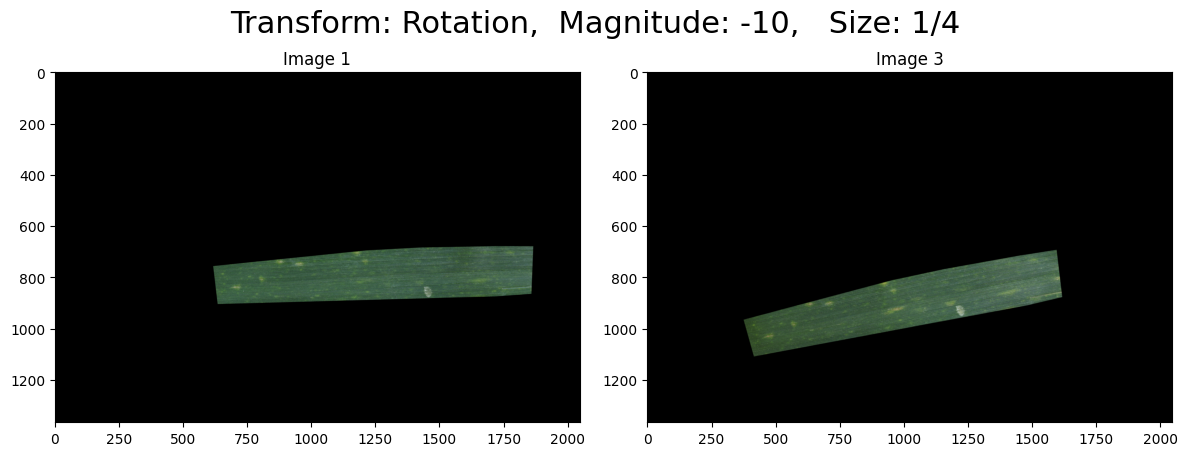

In [25]:
transform = "Rotation"
magnitude = -10
size_factor = 4
background = "Eroded"
fixed_img_ind = 1
moving_img_ind = 3

fixed_img_full, moving_img_full = fetch_leaves([fixed_img_ind, moving_img_ind], available_data, background_type=background)

if background == "Eroded+Cropped":
    # cropped images are likely of different dimensions -> pad them to match
    height = max(fixed_img_full.shape[-2], moving_img_full.shape[-2])
    width = max(fixed_img_full.shape[-1], moving_img_full.shape[-1])

    padder = K.augmentation.PadTo((height, width))

    fixed_img_full = padder(fixed_img_full)
    moving_img_full = padder(moving_img_full)
else:
    height = fixed_img_full.shape[-2]
    width = fixed_img_full.shape[-1]


H = int(height/size_factor)
W = int(width/size_factor)  
fixed_img = K.geometry.resize(fixed_img_full, (H, W), antialias=True)
moving_img = K.geometry.resize(moving_img_full, (H, W), antialias=True)
transformed_img = transform_img(moving_img, transform, magnitude)

fig, _ = plot_image_pair(fixed_img, transformed_img, fixed_img_ind, moving_img_ind, title=f"Transform: {transform},  Magnitude: {magnitude},   Size: 1/{size_factor}")
fig.show()
mkpts0, mkpts1, confidence, inliers, n_matches = loftr_match(fixed_img, transformed_img, verbose=True, return_n_matches=True)

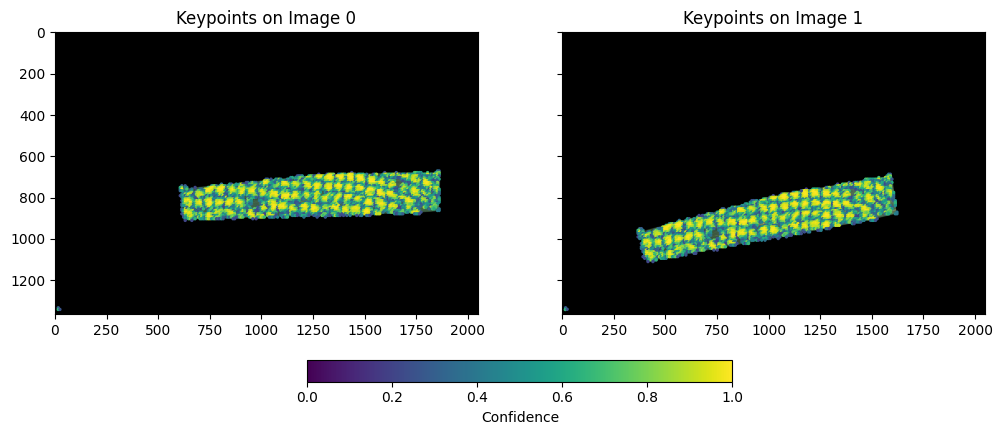

In [26]:
fig, _ = plot_match_coverage(fixed_img, mkpts0, transformed_img, mkpts1, confidence)
fig.show()

Setting threshold..
Threshold set to 0.95705032704
Estimating TPS transform...
Transforming moving image...


-----------------------
Results:
fixed_image: 1, moving_image: 3, background: Eroded, size: 1/4, transform: Rotation, magnitude: -10
total_matches: 3133, conf_matches: 2341, inliers: 712
mse: 0.005054056757729911, ssim: 0.9014172554016113, ncc: 0.6701759696006775, mi: 0.12547174096107483


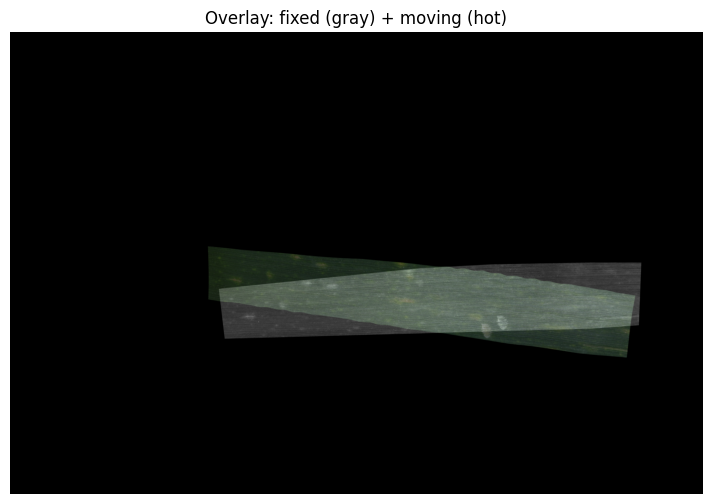

In [ ]:
# TPS
thrsld = 0.5

warped, tps = tps_skimage(mkpts0, mkpts1, confidence, thrsld, transformed_img, verbose=True)
mse_val = mean_squared_error(K.tensor_to_image(fixed_img), warped)
ssim_val, _ = ssim(K.tensor_to_image(fixed_img), warped, channel_axis=-1, data_range=(warped.max() - warped.min()), full=True) 
ncc_val = ncc(fixed_img, warped).item()
mi_val = mutual_information(fixed_img, warped).item()

print("-----------------------")
print("Results:")
print(f"fixed_image: {fixed_img_ind}, moving_image: {moving_img_ind}, background: {background}, size: 1/{size_factor}, transform: {transform}, magnitude: {magnitude}")
print(f"total_matches: {n_matches['total_matches']}, conf_matches: {int(n_matches['conf_matches'])}, inliers: {n_matches['inliers']}")
print(f"mse: {mse_val}, ssim: {ssim_val}, ncc: {ncc_val}, mi: {mi_val}")

fig = plot_overlay(fixed_img, warped)
fig.show()

# writer.writerow({'fixed_image': fixed_img_ind, 'moving_image': moving_img_ind, 'background': background, 'size': f"1/{size_factor}", 'transform': None, 'magnitude': None, 'total_matches': n_matches['total_matches'], 'conf_matches': int(n_matches['conf_matches']), 'inliers': n_matches['inliers'], 'mse': mse_val, 'ssim': ssim_val, 'ncc': ncc_val, 'mi': mi_val})